# Network of Spotify Genres - Analysis

![image.png](main.png)

In [53]:
import numpy as np
import pandas as pd
import cairocffi
import itertools
from igraph import *
import string

In this workbook, I will read the data files created from using the Spotify API and build a network of genres from their co-ocurrence matrix. Whenever 2 genres are tagged for the same artist, they will be added as an edge to the network, additionally the network will be weighted by the count of times 2 genres are tagged together

In [10]:
#Reading in artists data and removing artists without any genres tagged
artists = pd.read_csv('artists_nodes_gephi.csv')
artists = artists.loc[artists['genres'] != '[]']
len(artists)

86428

In [11]:
artists.sample(5)

,followers,genres,spotify id,Label,popularity,uri,strgnrs
75850,68,['classical percussion'],3pg5VHXLFQjl8xQA9mUZFB,Percussion Group Cincinnati,1,spotify:artist:3pg5VHXLFQjl8xQA9mUZFB,classical percussion
41609,10181,['rock chapin'],6V4aeixsxhlR6UEr4geYVP,Ricardo Andrade Y Los Ultimos Adictos,26,spotify:artist:6V4aeixsxhlR6UEr4geYVP,rock chapin
24847,19524,['glitch hop'],0uOUEsjCUSv2YvZmZtmBsX,Psymbionic,42,spotify:artist:0uOUEsjCUSv2YvZmZtmBsX,glitch hop
40829,24064,"['afro house', 'kwaito house']",3qFcd2aD9HCbpBO88l0Zff,DJ Merlon,25,spotify:artist:3qFcd2aD9HCbpBO88l0Zff,afro house_kwaito house
72351,8549,"['acoustic pop', 'indiecoustica']",6ls2l3WdMnYWKS0WQKghHK,Humming House,32,spotify:artist:6ls2l3WdMnYWKS0WQKghHK,acoustic pop_indiecoustica


As you can see, the genres column is a list of tags for each artist. To build a network from this column I will first, separate the tag and count all unique genres and every combination of genres that occur in the dataset. From this list of nodes and edges, I will have a weghted network

In [20]:
gnrs = []
for i in artists.index:
    tmpdict = {'genre': artists['strgnrs'][i].split("_"),'popularity': artists['popularity'][i],
              'followers': artists['followers'][i]}
    gnrs.append(tmpdict)
c = [{'genres': list(itertools.combinations(i['genre'],2)), 'popularity': i['popularity'], 'followers': i['followers']} for i in gnrs]


In [21]:
#Creating a list of edges from the combinations created above
edges = [{'edge': j, 'population': i['popularity'],'followers': i['followers']}  for i in c for j in i['genres']]
edges = pd.DataFrame.from_dict(edges)
edges = pd.DataFrame(edges.groupby(['edge']).agg(['mean','count']))
edges.columns = ['mean popularity','count','mean followers', 'all count']
edges = edges.reset_index()
edges = edges[['edge','mean popularity','count','mean followers']]


In [22]:
nodes = [{'node': j, 'population': i['popularity'],'followers': i['followers']}  for i in gnrs for j in i['genre']]
nodes = pd.DataFrame.from_dict(nodes)
nodes = pd.DataFrame(nodes.groupby(['node']).agg(['mean','count']))
nodes.columns = ['mean popularity','count','mean followers', 'all count']
nodes = nodes.reset_index()
nodes = nodes[['node','mean popularity','count','mean followers']]
# nodes = nodes[72:].reset_index(drop = True)

In [23]:
# Create graph
g = Graph()
g.add_vertices(nodes['node'])
g.add_edges(edges['edge'])
g.es['weight'] = edges['count']
g.es['popularity'] = edges['mean popularity']
g.es['followers'] = edges['mean followers']
g.vs['weight'] = nodes['count']
g.vs['popularity'] = nodes['mean popularity']
g.vs['followers'] = nodes['mean followers']
g.to_undirected()

## Understanding the Network

The network now has  4174 vertices and a pretty low density. Lower densities are typical as the network gets bigger.

In [24]:
print("Number of vertices:", g.vcount())
print("Number of edges:", g.ecount())
print("Density of the graph:", 2*g.ecount()/(g.vcount()*(g.vcount()-1)))

Number of vertices: 4174
Number of edges: 48759
Density of the graph: 0.0055986582234964525


Below we can see that the average degree is 23.91, while the max degree is pretty high. The top 10 vertices by degree are shown below. "Art Pop" seems to be the most connected genre. This would make more sense obnce you see the network, as it makes sense that a ambiguous, experimental genre like Art Pop would be associated with a wide variety of genres. The weighted degree which takes into account the edge weights shows a slightly different picture, we see that Rock seems to have the highest weighted degree. This is the metric we will use in our graph visualization.

In [25]:
degrees = []
total = 0
nodelength = len(nodes)

for n in range(nodelength):
    neighbours = g.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
    
print("Average degree:", total/nodelength)
print("Maximum degree:", max(degrees))
print("Vertex ID with the maximum degree:", degrees.index(max(degrees)))

Average degree: 23.363200766650696
Maximum degree: 323
Vertex ID with the maximum degree: 159


In [26]:
degreever = sorted(zip(g.degree(),g.vs), reverse = True)
for i in degreever[:10]:
    print("Vertex: "+i[1]['name']+", Degree: "+str(i[0]))

Vertex: art pop, Degree: 323
Vertex: rock, Degree: 299
Vertex: indie rock, Degree: 289
Vertex: modern rock, Degree: 278
Vertex: electronica, Degree: 275
Vertex: experimental, Degree: 262
Vertex: freak folk, Degree: 259
Vertex: indie pop, Degree: 249
Vertex: dance pop, Degree: 248
Vertex: pop rock, Degree: 239


In [40]:
weights = sorted(zip(g.strength(weights=g.es["weight"]),g.vs), reverse = True)
for i in weights[:10]:
    print("Vertex: "+i[1]['name']+", Weighted Degree: "+str(i[0]))

Vertex: rock, Weighted Degree: 4093.0
Vertex: indie rock, Weighted Degree: 3007.0
Vertex: folk rock, Weighted Degree: 2872.0
Vertex: dance pop, Weighted Degree: 2846.0
Vertex: roots rock, Weighted Degree: 2740.0
Vertex: edm, Weighted Degree: 2614.0
Vertex: hip hop, Weighted Degree: 2507.0
Vertex: alternative rock, Weighted Degree: 2490.0
Vertex: electro house, Weighted Degree: 2488.0
Vertex: indie pop, Weighted Degree: 2487.0


The distribution of degree is heavily right-skewed which is typical of real-world networks. The curve could also be close to a power-law distribution with alpha between 2 and 3, in which case it would be a Scale-Free network, I tried using the Kolmogorov-Smirnoff test to check if the data fit a power law distribution, but the hypothesis was rejected, so this isn't really a scale-free network

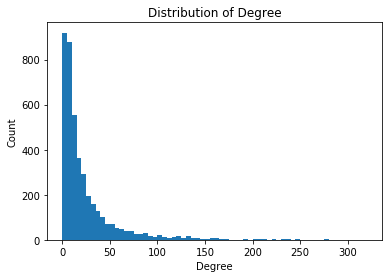

In [41]:
import matplotlib.pyplot as plt
plt.hist(g.degree(),bins = range(0,max(g.degree()),5))
plt.title("Distribution of Degree")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

In [48]:
result = power_law_fit(g.degree())
print(result.summary())

Fitted power-law distribution on discrete data

Exponent (alpha)  = 2.454340
Cutoff (xmin)     = 28.000000

Log-likelihood    = -4863.568282

H0: data was drawn from the fitted distribution

KS test statistic = 0.067088
p-value           = 0.000156

H0 rejected at significance level 0.05


Betweenness Centrality and Page Rank are 2 other measures that help us understand which nodes are most important for the flow of information. Betweenness Centrality is based on Shortest Paths from the node to all the other nodes and PageRank was the first algortihm used in google and was invented by its founders. It basically gives a probability distribution that details the likelood of landing at a given node (or genre, or webpage) when a person randomly clicks on nodes linked to their current node. 

In [47]:
betweenness = sorted(zip(g.betweenness(directed = False, weights=g.es["weight"]),g.vs), reverse = True)
for i in betweenness[:10]:
    print("Vertex: "+i[1]['name']+", Betweenness: "+str(i[0]))

Vertex: dance pop, Betweenness: 203981.0397091195
Vertex: art pop, Betweenness: 166374.84592816414
Vertex: experimental, Betweenness: 158835.657266869
Vertex: bow pop, Betweenness: 152847.32319806013
Vertex: world, Betweenness: 150645.38421775124
Vertex: afropop, Betweenness: 145094.71600556004
Vertex: electronica, Betweenness: 144642.45581768328
Vertex: latin alternative, Betweenness: 143913.74218047987
Vertex: downtempo, Betweenness: 130943.21243381788
Vertex: europop, Betweenness: 115325.26130911523


In [45]:
pgrnk = sorted(zip(g.pagerank(directed = False, weights=g.es["weight"]),g.vs), reverse = True)
for i in pgrnk[:10]:
    print("Vertex: "+i[1]['name']+", Page Rank: "+str(i[0]))

Vertex: art pop, Page Rank: 0.0021484964877041
Vertex: rock, Page Rank: 0.0019640351409563055
Vertex: indie rock, Page Rank: 0.0019463833865830916
Vertex: dance pop, Page Rank: 0.0019401695626421356
Vertex: electronica, Page Rank: 0.0019147254261371995
Vertex: modern rock, Page Rank: 0.0018955353104672082
Vertex: experimental, Page Rank: 0.0017958347861497129
Vertex: pop, Page Rank: 0.0017614548854342422
Vertex: freak folk, Page Rank: 0.001746417153245779
Vertex: indie pop, Page Rank: 0.0016837363171080632


## Community Detection

In this section, I have tried to run multiple community detection models and compared them against each other. I have tried most of the algorithms implemented in the iGraph Package. I am not going to go into detail into the algorithms, but one thing to know is modularity which is a measure used to understand how well the communities are strucured. Since this is usupervised learning, we can't have one measure that gives us an exact understanding of close to the truth the algorithm is, however, modularity is a close estimator of tight our communities are. 

$$Q = \sum_{i = 1}^{k}{(e_{ii}-a_{i}^2)}$$
where $e_{ii}$ is the probability that an edge would fall in module i and $a_{i}^2$ is the probabilty that a random edge would into a module i. Hence, networks with high modularity wouuld mean that there are dense connections between the nodes within modules but sparse connections between nodes in different modules. Modularity isn't perfect, however, it suffers a resolution limit (when there are communities within communities). 

In [49]:
models = {}
leiden1 = g.community_leiden(objective_function = 'modularity')
models["leiden1"] = leiden1
leiden2 = g.community_leiden(objective_function = 'CPM',weights=g.es["weight"])
models["leiden2"] = leiden2
wtrap = g.community_walktrap(weights=g.es["weight"])
clust=wtrap.as_clustering()
models["clust"] = clust
infomap = g.community_infomap(edge_weights=g.es["weight"], vertex_weights = g.vs['weight'])
models["infomap"] = infomap
labelprop = g.community_label_propagation(weights=g.es["weight"])
models["labelprop"] = labelprop
multilevel = g.community_multilevel(weights=g.es["weight"])
models["multilevel"] = multilevel

We can see that the Multilevel Algorithm gives the highest modularity. Multilevel Algorithm maximises the modularity of the network by considered a complete network with the same ertices and solving for a minimum cut problem, Multilevel Modularity also trie to solve for the resolution problem by providing different levels of cuts. I have also tried to compare the different community structures obtained by calculating the NMI (Normalised Mutual Information) of each of the community structures obtained, NMI of 1 means the structues are the exact same and nmi of 0 means they are completely different, since all the structues have nmi of over 0.5, we can possibly say that there is an underlying (if loose) structure and that our modularity isn't high through chance.

In [32]:
for mod in models.items():
    print("Modularity by "+ mod[0]+": "+str(mod[1].modularity))
    print("Number of clusters according to "+mod[0]+": "+str(len(mod[1])))

Modularity by leiden1: 0.5895997958907125
Number of clusters according to leiden1: 193
Modularity by leiden2: 0.5927912417386231
Number of clusters according to leiden2: 1930
Modularity by clust: 0.6397629348316202
Number of clusters according to clust: 535
Modularity by infomap: 0.673958622212069
Number of clusters according to infomap: 342
Modularity by labelprop: 0.6597714375398607
Number of clusters according to labelprop: 356
Modularity by multilevel: 0.7244519394937354
Number of clusters according to multilevel: 207


In [52]:
for i in range(6):
    for j in range(i+1, 6):
        print(list(models.items())[i][0]+", "+ list(models.items())[j][0]+ ": "+str(compare_communities(list(models.items())[i][1],list(models.items())[j][1], method = "nmi")))

leiden1, leiden2: 0.5580148791054518
leiden1, clust: 0.660986964140227
leiden1, infomap: 0.6706193916001028
leiden1, labelprop: 0.6727219864754933
leiden1, multilevel: 0.7130934818259026
leiden2, clust: 0.7428695342204658
leiden2, infomap: 0.7909825665353667
leiden2, labelprop: 0.7600149832754615
leiden2, multilevel: 0.642097568064561
clust, infomap: 0.8283618523559991
clust, labelprop: 0.8298391223853575
clust, multilevel: 0.7283246037105391
infomap, labelprop: 0.8644157542353473
infomap, multilevel: 0.7934499579763219
labelprop, multilevel: 0.7754558844041054


The really fun part is the actual visualization, that lets us see how different genres "flow" into each other. However, iGraph will not be able to handle visualizing a graph of this size efficiently, so we will use gephi (open sorce graph visualization software) for the actual visualization. I have used the Multilevel Algorithm to create Community IDs and color code the nodes so we can see the structure of the network. The full network is visualized here: https://manasahariharan.github.io/Spotify-Artist-Networks/
